In [2]:
import tensorflow as tf
import tools.mnist as mnist_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# labeled samples used per class
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
unsup_batch_size = 100


learning_rate = 1e-3
decay_steps = 5000
decay_factor = 0.33
visit_weight = 0.0

max_steps = 10000
eval_interval = 500

log_dir = "logs/model-20000"

seed = None

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

# gets sup_per_class samples for each class

# [10 (classes), 10 (samples), 28, 28, 1]

sup_by_label = semisup.sample_by_label(train_images, train_labels,
                        sup_per_class, NUM_LABELS, seed)

In [5]:
from ipywidgets import IntProgress, Layout

graph = tf.Graph()


with graph.as_default():
    
    model = semisup.SemisupModel(arch.mnist_model, NUM_LABELS, IMAGE_SHAPE)
    
    # iterator = up.create_input(train_images, train_labels, unsup_batch_size)
    # t_unsup_images, _ = up.create_input(train_images, train_labels, unsup_batch_size)
    
    #it = up.create_input(train_images, train_labels, unsup_batch_size)
    #t_unsup_images,_ = it.get_next()
    
    unsup_data = up.create_input(train_images, train_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    
    sup_data = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    sup_it   = sup_data.make_one_shot_iterator()
    
    item       = sup_it.get_next()
    temp_unzip = (list(zip(*item)))
    t_sup_images, t_sup_labels = tf.concat(temp_unzip[0], 0), tf.concat(temp_unzip[1], 0)
    
    #t_sup_images, t_sup_labels = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver()

---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/fully_c

In [ ]:
from IPython.display import display

f = IntProgress(min=0, max=max_steps, layout= Layout(width="90%")) # instantiate the bar
display(f) # display the bar

with tf.Session(graph=graph) as sess:
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 1
    
    for step in range(max_steps):
        try:
            _, summaries = sess.run([train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            _, summaries = sess.run([train_op, summary_op])
            
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step + 1) % eval_interval == 0 or step == 99:
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {model.step}")
            saver.save(sess, log_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='90%'), max=10000)

Step: 99
[[5738    7   14    1    7    8   78    2   37   31]
 [   4 6543   49   10   70    6   19   14   27    0]
 [  52   58 5059  112  115    1   59  155  237  110]
 [  25   12  105 5582   32   30   14   52  228   51]
 [   6   35    9    2 5264    1  126    9   28  362]
 [ 129   34   23  257   52 4386   57   26  417   40]
 [  95   49    6    4   15   92 5605    0   48    4]
 [  18   38   78  109  124    1    1 5580   11  305]
 [  21  172   36  145   47   81   28    8 5233   80]
 [  83   29   18   77  290   21   21  309   97 5004]]
Test error: 10.01 %

saving model - step <tf.Variable 'global_step:0' shape=() dtype=int64_ref>
Step: 499
[[5746    7   11    2    3   18   56    2   31   47]
 [   3 6544   47   15   74    4   14   15   22    4]
 [  33   48 5176   56  114    2   32  202  210   85]
 [  17    8  120 5579   39   36    7   83  179   63]
 [   5   39    7    0 5305    1   82   11   23  369]
 [  75   24   20  181   27 4743   44   39  220   48]
 [  72   45    3    4   12   92 5663

In [6]:
train_step = 8500
model_checkpoint = f"{log_dir}-{train_step}"

with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    embedded_unsup = sess.run(t_unsup_emb)

INFO:tensorflow:Restoring parameters from logs/model-20000-8500


In [7]:
similarity = embedded_sup.dot(embedded_sup.T)
similarity.shape

(100, 100)

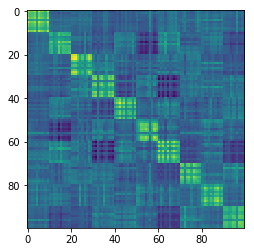

In [8]:
import matplotlib.pyplot as plt

plt.imshow(similarity)

INFO:tensorflow:Restoring parameters from logs/model-20000-6500


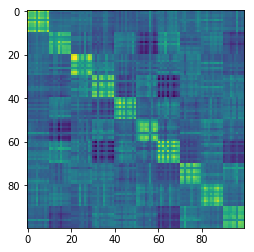

In [9]:
train_step = 6500
model_checkpoint = f"{log_dir}-{train_step}"

with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    labels_unsup, embedded_unsup = sess.run([t_unsup_labels, t_unsup_emb])
    
    unsup = list(zip(labels_unsup, embedded_unsup))
    unsup.sort(key=lambda x: x[0])
    embedded_unsup = [pair[1] for pair in unsup]
    
similarity = embedded_sup.dot(embedded_sup.T)
similarity.shape

import matplotlib.pyplot as plt

plt.imshow(similarity)

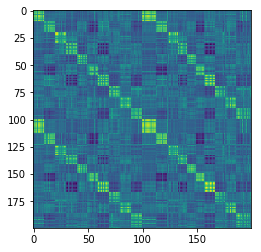

In [12]:
stacked = np.vstack((embedded_sup, embedded_unsup))

similarity = stacked.dot(stacked.T)
similarity.shape

import matplotlib.pyplot as plt
# similarity[similarity<0]= 0
plt.imshow(similarity)

INFO:tensorflow:Restoring parameters from logs/model-20000-6500


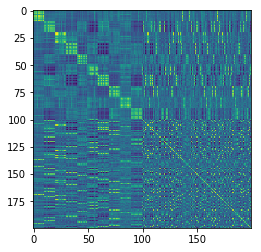

In [13]:
with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    _, embedded_unsup = sess.run([t_unsup_labels, t_unsup_emb])
    
    stacked = np.vstack((embedded_sup, embedded_unsup))

similarity = stacked.dot(stacked.T)
plt.imshow(similarity)